In [51]:
import numpy as np
import pandas as pd
import os
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
import torchmetrics
from torchmetrics import Metric
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
from torch.nn.utils.rnn import pad_sequence
from pytorch_lightning.callbacks import ModelCheckpoint
from torchvision.datasets import CocoDetection
import copy
import math
from PIL import Image
import cv2
import albumentations as A 
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes
import matplotlib.pyplot as plt
import sys
%matplotlib inline
print(torch.__version__)
print(torchvision.__version__)
from pycocotools.coco import COCO
from albumentations.pytorch import ToTensorV2
#import wandb
import matplotlib.patches as patches



2.2.1+cu121
0.17.1+cu121


# Hyper paramaters

In [52]:
# Hyperparameters
batch_size = 8
num_epochs= 1
lr = 0.0001
squared_gradient = 0.999
momentum = 0.9
image_size = [600, 600]
wandb_on = False
device_cuda = "GPU" # GPU or CPU
model_name = "hurtig" # hurtig or god

num_workers = 0
if wandb_on:
    wandb.login()

    wandb.init(
        # set the wandb project where this run will be logged
        project="Bachelor0386",
        
        # track hyperparameters and run metadata
        config={
        "architecture": "Faster RCNN",
        "dataset": "CustomDataset",
        "epochs": 1,
        }
    )

if device_cuda == "GPU":
    print("Using GPU")
    device = torch.device("cuda") # use GPU to train
elif device_cuda == "CPU":
    print("Using CPU")
    device = "cpu"


Using GPU


# Transforms

In [53]:

def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(image_size[0], image_size[1]), 
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
         transform = A.Compose([
             A.Resize(image_size[0], image_size[1]), 
             ToTensorV2()
         ], bbox_params=A.BboxParams(format='coco'))
    return transform

# Data Import

In [54]:
class PotholeDetectionClass(datasets.VisionDataset):
    def __init__(self, root, stage='/train', transform=None, target_transform=None, transforms=None, batch_size = batch_size):
        super().__init__(root, transforms, transform, target_transform)
        self.stage = stage #train, valid, test
        self.coco = COCO(root + stage + "/_annotations.coco.json") # annotations stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]
        self.batch_size = batch_size

    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        path = "/" + path
        image = cv2.imread(self.root + self.stage + path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))

    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))

        boxes = [t['bbox'] + [t['category_id']] for t in target]

        transformed = self.transforms(image=image, bboxes=boxes)
        image = transformed['image']
        boxes = transformed['bboxes']

        new_boxes = []
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.tensor(new_boxes, dtype=torch.float32)

        targ = {}
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # we have a different area
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        image = torch.tensor(image, dtype=torch.float32).div(255)

           # Convert target dictionary into tensors
        targ = {key: torch.tensor(val) for key, val in targ.items()}
        return image, targ # scale images
    
    def __len__(self):
        return len(self.ids)
    
dataset_path = "/Pothole_coco"
dataset_path = os.getcwd() + dataset_path

coco = COCO(dataset_path + "/train" + "/_annotations.coco.json")
categories = coco.cats
n_classes = len(categories.keys())

train_dataset = PotholeDetectionClass(root=dataset_path, transforms=get_transforms(True))
test_dataset = PotholeDetectionClass(root=dataset_path, stage='/test', transforms=get_transforms(False))
valid_dataset = PotholeDetectionClass(root=dataset_path, stage= "/valid", transform=get_transforms(False))

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


# Model 

In [55]:

if model_name == "hurtig":
    model = models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True)    # hurtig
elif model_name == "god":
    model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)                   # god

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

# Cuda
model = model.to(device)

C:\Users\tobia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\tobia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# DataLoader

In [56]:
def custom_collate(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, collate_fn=custom_collate)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=custom_collate)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=custom_collate)

# Optimizer

In [57]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=lr, weight_decay=1e-4) # to change adam use F12 and changes betas
#optimizer = torch.optim.Adam(params, lr=0.001)
#optimizer = torch.optim.PSO(params, lr=0.001) #particle swarm optimization

# Additional

In [58]:
def plot_image(img_tensor, annotation,phase='train'):

    fig,ax = plt.subplots(1)
    img = img_tensor.cpu()

    ax.imshow(img.permute(1, 2, 0))
    for idx,box in enumerate(annotation["boxes"]):
      
        xmin, ymin, xmax, ymax = box
        color=['r','g','b','r']
        classes=['no mask','Masked','Improper masking','No-mask']
        # Create a Rectangle patch
        rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=3,edgecolor=color[annotation['labels'][idx]],facecolor='none')
        ax.text(xmin, ymin, classes[annotation['labels'][idx]],color='black',bbox=dict(facecolor=color[annotation['labels'][idx]], alpha=0.1))
        # Add the patch to the Axes
        ax.add_patch(rect)
    plt.show()
    
    

def accuracyMetric(preds,annotations):
    non_accurate=0
    accurate=0
    def csm(A,B,corr):
        if corr:
            B=B-B.mean(axis=1)[:,np.newaxis]
            A=A-A.mean(axis=1)[:,np.newaxis]
        num=np.dot(A,B.T)
        p1=np.sqrt(np.sum(A**2,axis=1))[:,np.newaxis]
        p2=np.sqrt(np.sum(B**2,axis=1))[np.newaxis,:]
        return 1-(num/(p1*p2))
    inds=torch.where((preds['scores'])>0.91)
    distMatrix=csm(np.array(preds['boxes'][inds].cpu()),np.array(annotations['boxes'].cpu()),True)

    for i in range (distMatrix.shape[0]):
        cla=np.argmin(distMatrix[i,:])

        if preds['labels'][i]%3==annotations['labels'][cla]:
            accurate+=1
        else:
            non_accurate+=1
    allSamp=np.max(((accurate+non_accurate),len(annotations['labels'])))
    return (accurate/allSamp)

# Neural Network

In [59]:
from torchmetrics import JaccardIndex, Precision, Recall
from torchmetrics.classification import *



class NN(pl.LightningModule):
    def __init__(self, model, optimizer, train_loader, test_loader, image_plot_id = 0):
        super().__init__()
        #self.accuracy = BinaryAccuracy()
        self.model = model
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.thresh  =  0.5
        self.test_loader = test_loader
        self.losses_dict = []
        self.save_hyperparameters()

    
        self.image_plot_id = image_plot_id

        self.accuracy = BinaryAccuracy()
        self.loss = nn.BCEWithLogitsLoss() # Binary Cross-Entropy Loss
        self.recall = BinaryRecall(threshold=self.thresh)
        self.prec = BinaryPrecision()
        self.jacq_ind = BinaryJaccardIndex()
        

    # def forward(self, images, target):
    #     return self.model(images, target)

    def forward(self, x, annotations, phase='train'):
        if phase=='train':
            print(annotations)
            out=self.model(x,annotations)
        else:
            self.model.eval()
            out=model(x[0])
        # no activation and no softmax at the end
        return out

   

    # def training_step(self, batch, batch_idx):
    #     imgs, annotations = batch
    #     optimizer.zero_grad()
    #     loss_dict = self.model(imgs, annotations)
    #     losses = sum(loss for loss in loss_dict.values())
    #     optimizer.step()
    #     if wandb_on:
    #         wandb.log({"train/loss": losses})
    #     return losses
    
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        print("før")
        print(batch)
        logits = self(x)
        print("efter")
        loss = self.loss(logits, y)
        print(loss)
        
        # training metrics
        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds, y)
        
        recall = self.recall(preds, y)
        precision = self.prec(preds, y)
        jac = self.jacq_ind(preds, y)

        if wandb_on:
            wandb.log({"train/loss": loss, "train/accuracy": acc, "train/recall": recall, "train/precision": precision, "train/jacc": jac})
        #self.log('train_loss', loss, on_step=True, on_epoch=True, logger=True)
        #self.log('train_acc', acc, on_step=True, on_epoch=True, logger=True)
        #self.log('train_recall', recall, on_step=True, on_epoch=True, logger=True)
        #self.log('train_precision', precision, on_step=True, on_epoch=True, logger=True)
        #self.log('train_jacc', jac, on_step=True, on_epoch=True, logger=True)
        return loss

    def test_step(self,batch,batch_idx):
        imgs, annotations = batch
        
        #imgs = list(img for img in imgs)
        annotations = [{k: v for k, v in t.items()} for t in annotations]
        preds = self(list([imgs]),phase='test')
        #print(preds['labels'])
        
        # plot_image(imgs[0], preds[0])
        # plot_image(imgs[0], annotations[0],phase='test')
        classes = [i[1]['name'] for i in categories.items()]
        
        #for i in range(len(imgs)): #test_dataset.__len__()-30
        print(len(imgs))
        img, _ = test_dataset[self.image_plot_id]
        self.image_plot_id = self.image_plot_id+1
        img_int = torch.tensor(img*255, dtype=torch.uint8)
        with torch.no_grad():
            prediction = model([img.to(device)])
            pred = prediction[0]
            fig = plt.figure(figsize=(14, 10))
        plt.imshow(draw_bounding_boxes(img_int,
            pred['boxes'][pred['scores'] > 0.6],
            [classes[i] for i in pred['labels'][pred['scores'] > 0.6].tolist()], width=4
        ).permute(1, 2, 0))
        self.log('accuracy',(accuracyMetric(preds[0], annotations[0])))
        print((accuracyMetric(preds[0], annotations[0])))

    
    
    def configure_optimizers(self):
        return self.optimizer

    def train_dataloader(self):
        return self.train_loader

    def test_dataloader(self):
        return self.test_loader

    # def load_from_checkpoint(cls, checkpoint_path, model, optimizer, train_loader, test_loader):
    #     model = model.load_from_checkpoint(checkpoint_path)
    #     return cls(model, optimizer, train_loader, test_loader)

    

# Training

In [60]:
lightning_module = NN(model, optimizer, train_loader, test_loader)
# Initialize a Lightning Trainer
if wandb_on:
    wandb_logger = WandbLogger(project='Bachelor', job_type='train')
    wandb_logger.watch(model, log="all")
    trainer = pl.Trainer(max_epochs=num_epochs,logger=wandb_logger)  # You can adjust the Trainer options
else:
    trainer = pl.Trainer(max_epochs=num_epochs)
# Start training


trainer.fit(lightning_module, train_loader)

if wandb_on:
    wandb.finish()

C:\Users\tobia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pytorch_lightning\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params
------------------------------------------------
0 | model    | FasterRCNN         | 18.9 M
1 | accuracy | BinaryAccuracy     | 0     
2 | loss     | BCEWithLogitsLoss  | 0     
3 | recall   | BinaryRecall       | 0     
4 | prec     | BinaryPrecision    | 0     
5 | jacq_ind | BinaryJaccardIndex | 0     
------------------------------------------------
18.9 M    Trainable params
58.9 K    Non-trainable params
18.9 M    Total params
75.721    Total estimated model params size (MB)


Epoch 0:   0%|          | 0/59 [06:16<?, ?it/s]


C:\Users\tobia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 0:   0%|          | 0/59 [00:00<?, ?it/s] 

C:\Users\tobia\AppData\Local\Temp\ipykernel_9968\3980220647.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32).div(255)
C:\Users\tobia\AppData\Local\Temp\ipykernel_9968\3980220647.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targ = {key: torch.tensor(val) for key, val in targ.items()}


før
((tensor([[[0.3412, 0.3765, 0.4039,  ..., 0.4431, 0.4392, 0.4510],
         [0.3490, 0.3804, 0.4118,  ..., 0.4353, 0.4275, 0.4471],
         [0.3608, 0.3961, 0.4157,  ..., 0.4235, 0.4118, 0.4353],
         ...,
         [0.4157, 0.2078, 0.0706,  ..., 0.1216, 0.1255, 0.1255],
         [0.3098, 0.1373, 0.0275,  ..., 0.1255, 0.1255, 0.1294],
         [0.2588, 0.1020, 0.0118,  ..., 0.1255, 0.1255, 0.1294]],

        [[0.3373, 0.3725, 0.4039,  ..., 0.3882, 0.3843, 0.3961],
         [0.3412, 0.3765, 0.4118,  ..., 0.3804, 0.3725, 0.3922],
         [0.3569, 0.3922, 0.4196,  ..., 0.3686, 0.3569, 0.3804],
         ...,
         [0.4275, 0.2157, 0.0784,  ..., 0.1412, 0.1451, 0.1451],
         [0.3216, 0.1451, 0.0392,  ..., 0.1451, 0.1490, 0.1490],
         [0.2667, 0.1059, 0.0196,  ..., 0.1490, 0.1490, 0.1529]],

        [[0.3020, 0.3373, 0.3686,  ..., 0.4275, 0.4235, 0.4353],
         [0.3059, 0.3412, 0.3725,  ..., 0.4196, 0.4118, 0.4314],
         [0.3216, 0.3569, 0.3843,  ..., 0.4078, 0.39

TypeError: NN.forward() missing 1 required positional argument: 'annotations'

# Testing

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


C:\Users\tobia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

C:\Users\tobia\AppData\Local\Temp\ipykernel_23452\3980220647.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32).div(255)
C:\Users\tobia\AppData\Local\Temp\ipykernel_23452\3980220647.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targ = {key: torch.tensor(val) for key, val in targ.items()}


Testing DataLoader 0:   0%|          | 0/9 [00:00<?, ?it/s]8
0.0
Testing DataLoader 0:  11%|█         | 1/9 [00:00<00:00, 15.51it/s]

C:\Users\tobia\AppData\Local\Temp\ipykernel_23452\4116429656.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_int = torch.tensor(img*255, dtype=torch.uint8)


8
0.0
Testing DataLoader 0:  22%|██▏       | 2/9 [00:00<00:00, 12.52it/s]8
0.0
Testing DataLoader 0:  33%|███▎      | 3/9 [00:00<00:00, 11.94it/s]8
0.0
Testing DataLoader 0:  44%|████▍     | 4/9 [00:00<00:00, 11.76it/s]8
0.0
Testing DataLoader 0:  56%|█████▌    | 5/9 [00:00<00:00, 11.35it/s]8
0.0
Testing DataLoader 0:  67%|██████▋   | 6/9 [00:00<00:00, 10.97it/s]8
0.0
Testing DataLoader 0:  78%|███████▊  | 7/9 [00:00<00:00, 10.84it/s]8
0.0
Testing DataLoader 0:  89%|████████▉ | 8/9 [00:00<00:00, 10.69it/s]2
0.0
Testing DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 11.19it/s]


C:\Users\tobia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\utils.py:209: UserWarning: boxes doesn't contain any box. No box was drawn
  warnings.warn("boxes doesn't contain any box. No box was drawn")


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         accuracy          │            0.0            │
└───────────────────────────┴───────────────────────────┘

[{'accuracy': 0.0}]

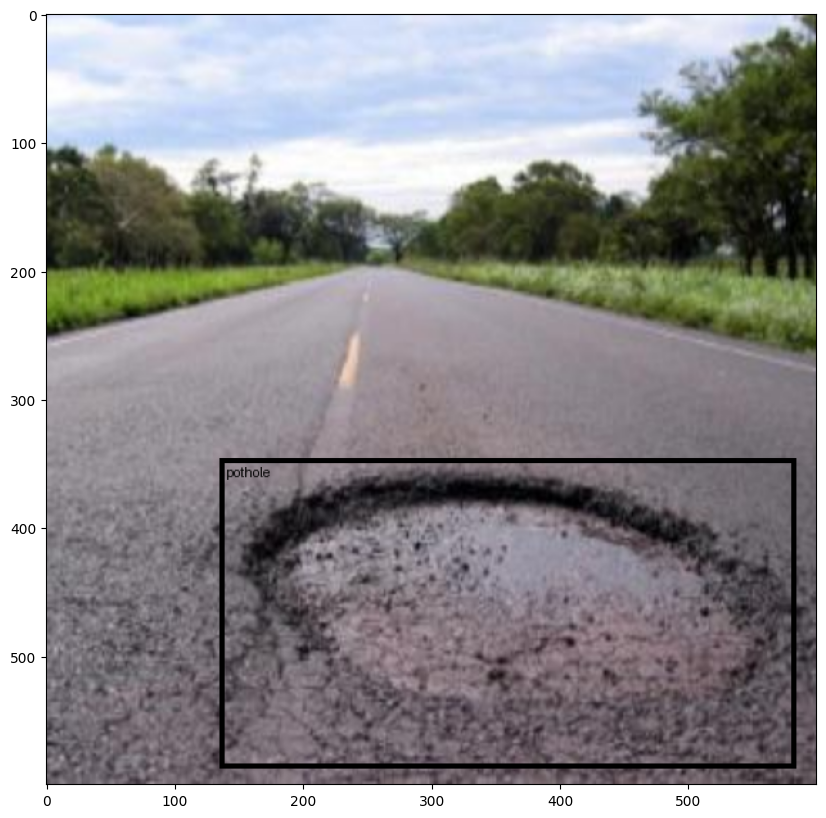

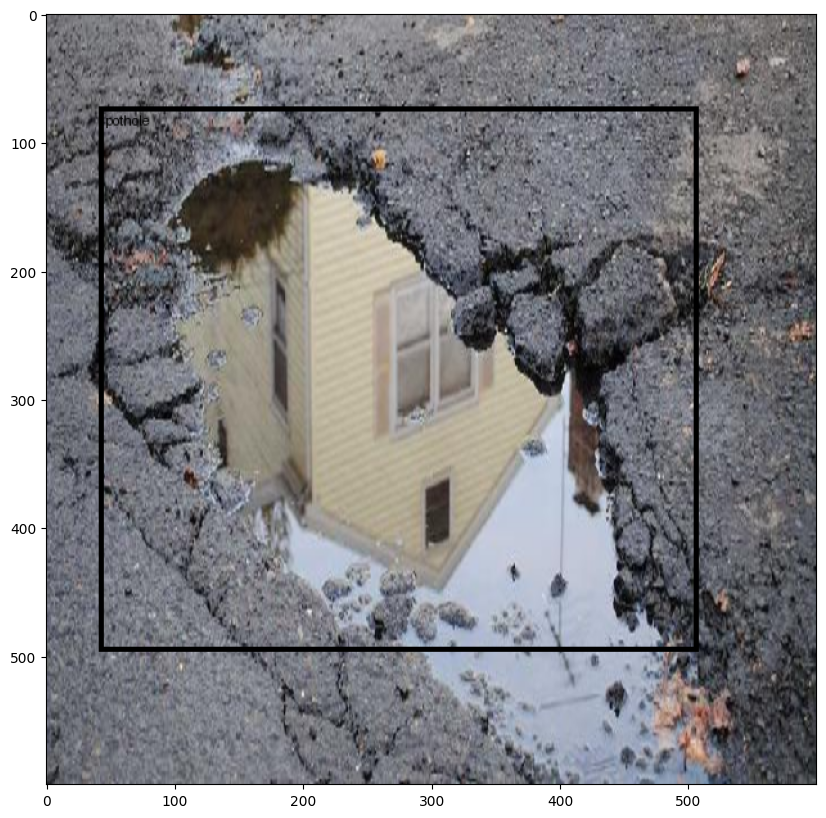

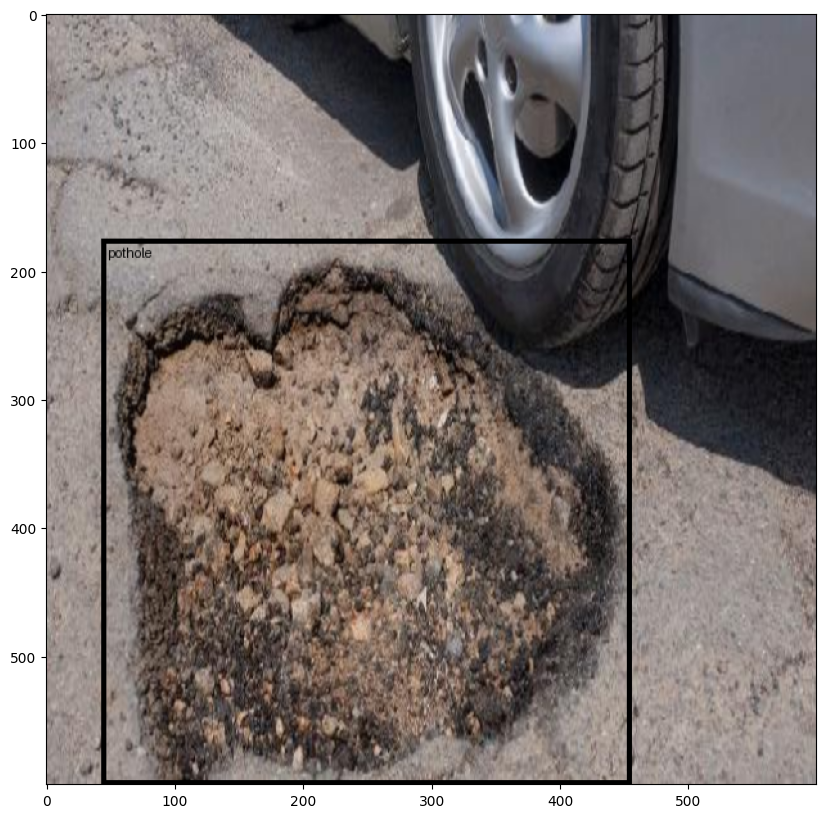

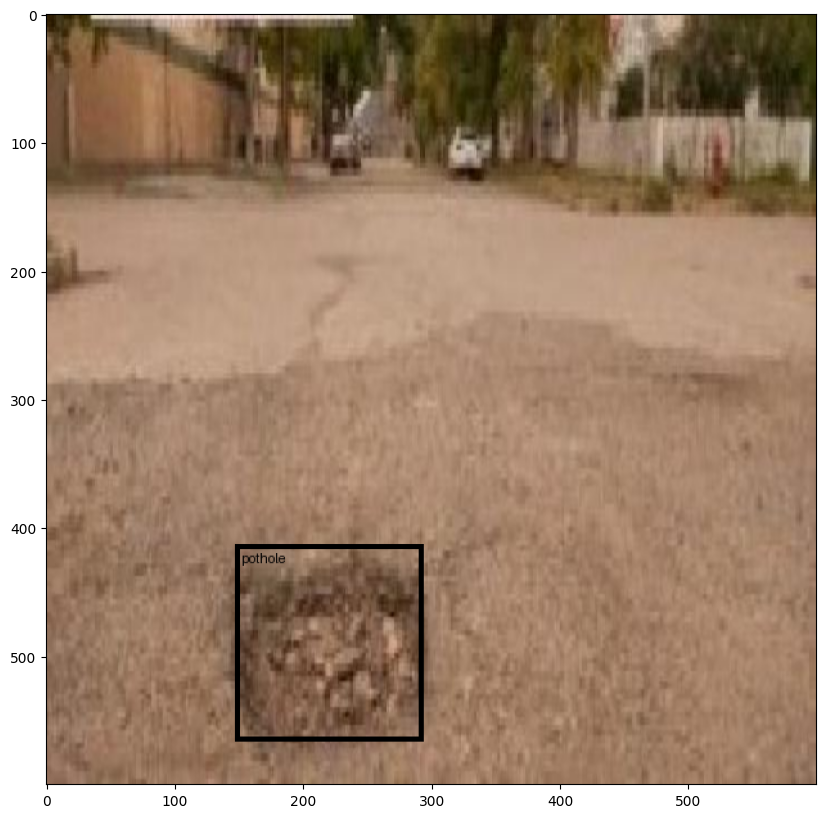

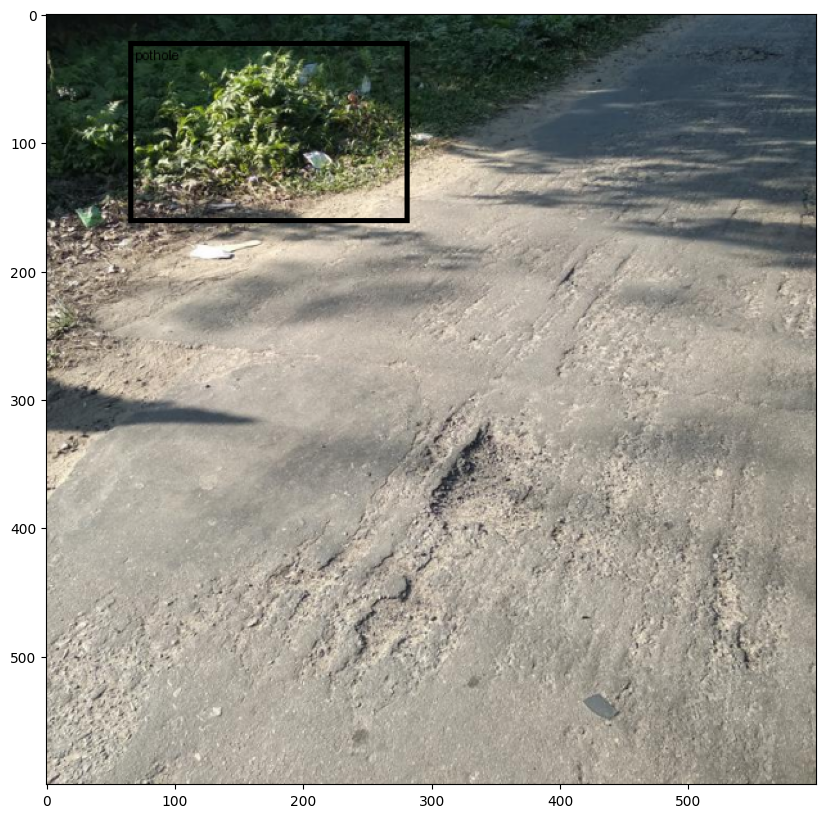

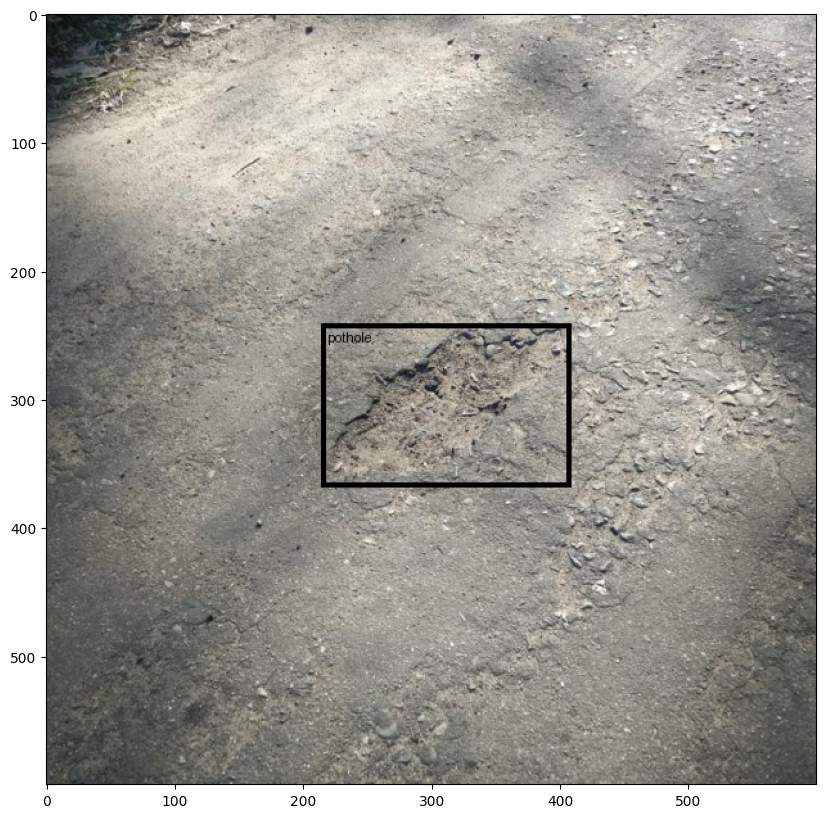

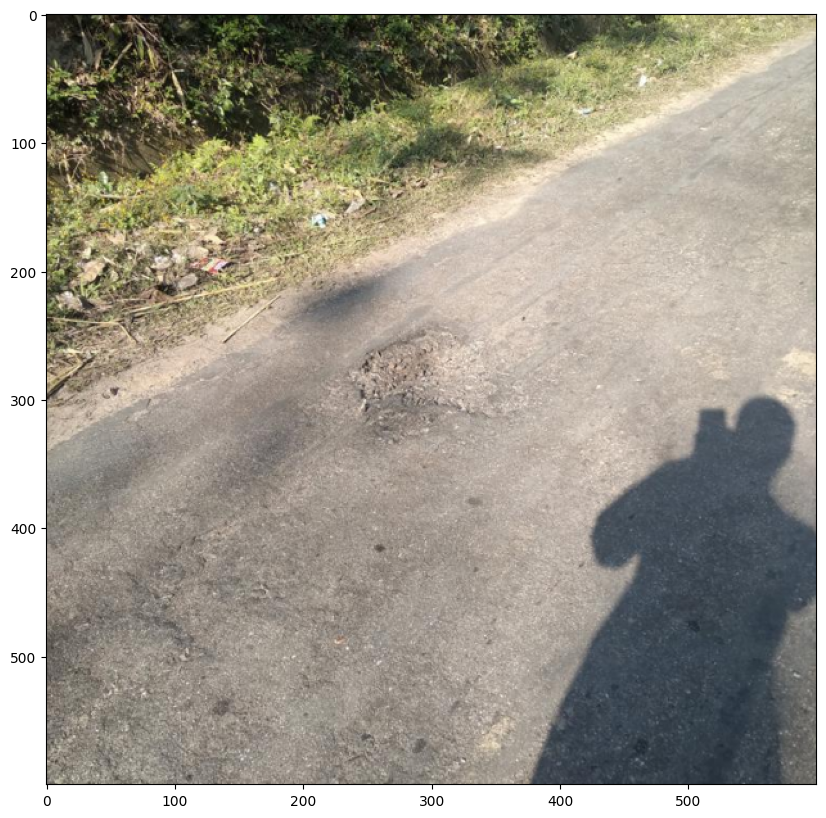

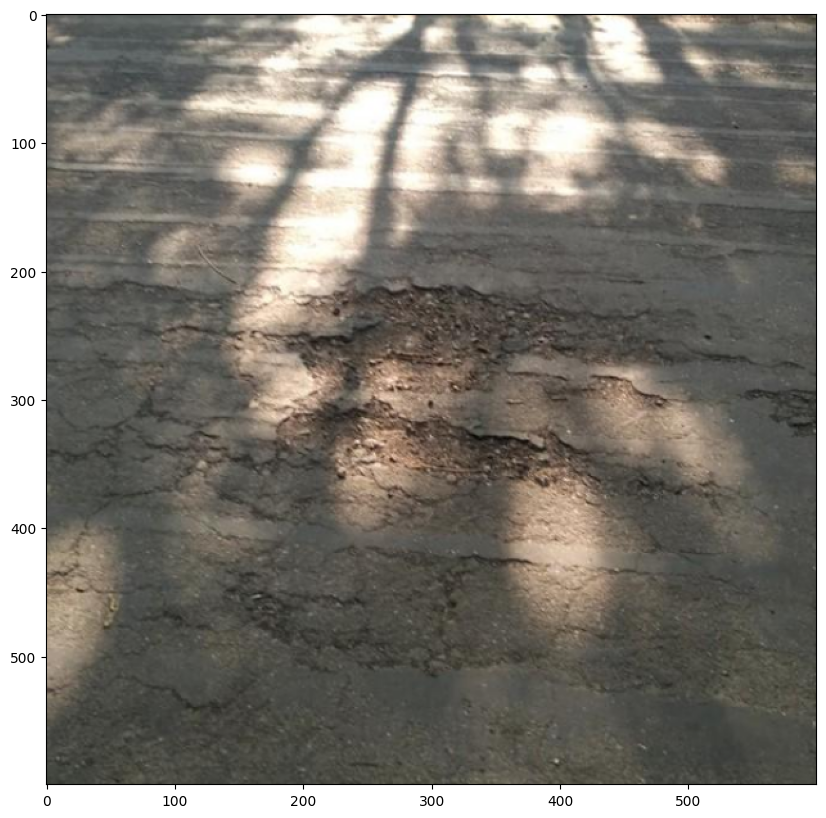

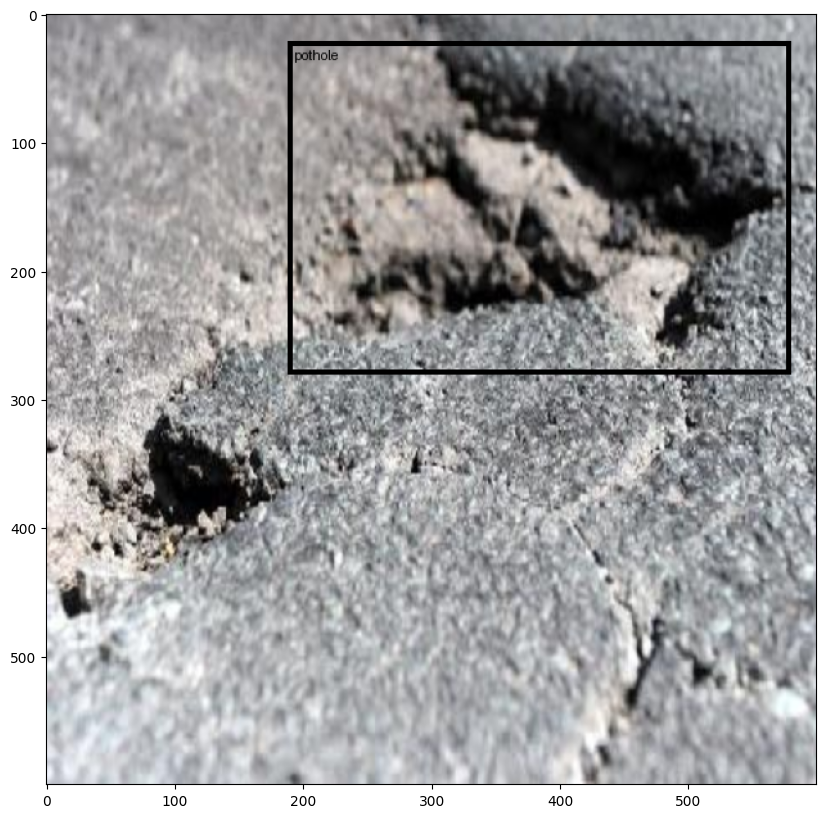

In [ ]:
trainer.test(lightning_module, test_loader)